In [1]:
# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from tensorflow.keras.layers import concatenate, BatchNormalization, Input
from tensorflow.keras.layers import add
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt # for plotting data
import cv2

In [2]:
# Function to load descriptions, updated to handle the header and comma separator
def load_description(text):
    mapping = dict()
    lines = text.split("\n")

    # Skip the header line
    for line in lines[1:]:
        token = line.split(",")  # Split by comma since the file uses comma separator

        # Ensure there are at least 2 elements after splitting
        if len(token) < 2:
            continue

        img_id = token[0].split('.')[0].strip()  # Get image ID and strip whitespace
        img_des = token[1].strip()               # Get image description and strip whitespace

        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)

    return mapping

# Correct the file path
token_path = r'C:\Users\Lahari\OneDrive\Desktop\image caption\dataset\captions.txt'
text = open(token_path, 'r', encoding='utf-8').read()
descriptions = load_description(text)

# Debug: Print first few keys to check if the issue is resolved
print("Sample Keys:", list(descriptions.keys())[:5])

# Use get() to safely access the key
print(descriptions.get('1000268201_693b08cb0e', "Key not found"))

Sample Keys: ['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615']
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [3]:
# Import required module
import string

# Function to clean descriptions
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            # Remove punctuation
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            # Split into words, convert to lowercase, and remove short/non-alphabetical words
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

# Clean the descriptions
clean_description(descriptions)

# Check the cleaned descriptions
print(descriptions['1000268201_693b08cb0e'])

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [4]:
def to_vocab(desc):
	words = set()
	for key in desc.keys():
		for line in desc[key]:
			words.update(line.split())
	return words
vocab = to_vocab(descriptions)

In [5]:
import glob 
from keras.preprocessing.image import load_img, img_to_array 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
import numpy as np

# Get the correct list of images with full paths
images = r'C:\Users\Lahari\OneDrive\Desktop\image caption\dataset\Images'
img = glob.glob(images + '*.jpg') 

# Check if images are detected
print("Sample Image Paths:", img[:5])  # Show a few full paths

# Create train_img list with full paths
train_img = []
for im in img: 
    img_name = im.split('/')[-1]  # Get only the filename
    if img_name in train_images:  # Check if the filename is in train_images list
        train_img.append(im)  # Store the full path

# Verify if training images are detected
print("Total Training Images Found:", len(train_img))
print("Sample Training Image Paths:", train_img[:5])

# Preprocess the image for InceptionV3
def preprocess_img(img_path): 
    img = load_img(img_path, target_size=(299, 299)) 
    x = img_to_array(img) 
    x = np.expand_dims(x, axis=0) 
    x = preprocess_input(x) 
    return x 

# Encode the image into feature vectors
def encode(image): 
    image = preprocess_img(image) 
    vec = model.predict(image) 
    vec = np.reshape(vec, (vec.shape[1])) 
    return vec 

# Load pre-trained InceptionV3 model + higher level layers
base_model = InceptionV3(weights='imagenet') 
model = Model(base_model.input, base_model.layers[-2].output) 

# Run the encode function on all train images and store the feature vectors in a dictionary
encoding_train = {}
for img in train_img: 
    img_name = img.split('/')[-1]  # Extract just the filename
    encoding_train[img_name] = encode(img)  # Use full path for encoding

print("Encoding completed. Total encoded images:", len(encoding_train))


Sample Image Paths: []
Total Training Images Found: 0
Sample Training Image Paths: []
Encoding completed. Total encoded images: 0


In [6]:
from keras.preprocessing.image import load_img, img_to_array 
def preprocess_img(img_path): 
	# inception v3 excepts img in 299 * 299 * 3 
	img = load_img(img_path, target_size = (299, 299)) 
	x = img_to_array(img) 
	# Add one more dimension 
	x = np.expand_dims(x, axis = 0) 
	x = preprocess_input(x) 
	return x 

def encode(image): 
	image = preprocess_img(image) 
	vec = model.predict(image) 
	vec = np.reshape(vec, (vec.shape[1])) 
	return vec 

base_model = InceptionV3(weights = 'imagenet') 
model = Model(base_model.input, base_model.layers[-2].output) 
# run the encode function on all train images and store the feature vectors in a list 
encoding_train = {} 
for img in train_img: 
	encoding_train[img[len(images):]] = encode(img) 



In [7]:
# Initialize train_descriptions from cleaned descriptions
train_descriptions = descriptions  # Use the cleaned descriptions

# Proceed with your existing code
all_train_captions = [] 
for key, val in train_descriptions.items(): 
    for caption in val: 
        all_train_captions.append(caption) 

# consider only words which occur atleast 10 times 
vocabulary = vocab 
threshold = 10  # you can change this value according to your need 
word_counts = {} 
for cap in all_train_captions: 
    for word in cap.split(' '): 
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold] 

# word mapping to integers 
ixtoword = {} 
wordtoix = {} 

ix = 1
for word in vocab: 
    wordtoix[word] = ix 
    ixtoword[ix] = word 
    ix += 1

# find the maximum length of a description in the dataset 
max_length = max(len(des.split()) for des in all_train_captions) 
print("Maximum caption length:", max_length)



Maximum caption length: 29


In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import os
import glob

# Load InceptionV3 model for feature extraction
base_model = InceptionV3(weights='imagenet') 
model = Model(base_model.input, base_model.layers[-2].output)

# Preprocess the image for InceptionV3
def preprocess_img(img_path): 
    img = load_img(img_path, target_size=(299, 299)) 
    x = img_to_array(img) 
    x = np.expand_dims(x, axis=0) 
    x = preprocess_input(x) 
    return x 

# Encode the image into feature vectors
def encode(image): 
    image = preprocess_img(image) 
    vec = model.predict(image) 
    vec = np.reshape(vec, (vec.shape[1])) 
    return vec 

# Directory containing all training images
images_dir = r'C:\Users\Lahari\OneDrive\Desktop\image caption\dataset\Images'
img_paths = glob.glob(images_dir + '/*.jpg') 

# Extract features and store them in train_features
train_features = {}
for img_path in img_paths:
    img_id = os.path.basename(img_path).split('.')[0]
    train_features[img_id] = encode(img_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

In [9]:
# Define vocab_size before using it
vocab_size = len(wordtoix) + 1 

X1, X2, y = list(), list(), list() 
for key, des_list in train_descriptions.items(): 
    pic = train_features[key]  # Use key without .jpg extension
    for cap in des_list: 
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix] 
        for i in range(1, len(seq)): 
            in_seq, out_seq = seq[:i], seq[i] 
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0] 
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] 
            # Store the sequences
            X1.append(pic) 
            X2.append(in_seq) 
            y.append(out_seq) 

X2 = np.array(X2) 
X1 = np.array(X1) 
y = np.array(y)


In [10]:
print(list(train_features.keys())[:5])


['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615']


In [11]:
train_features[img_id + '.jpg'] = encode(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


In [12]:
# Define embedding dimension
emb_dim = 200  

# Define the model 
ip1 = Input(shape=(2048, )) 
fe1 = Dropout(0.2)(ip1) 
fe2 = Dense(256, activation='relu')(fe1) 

ip2 = Input(shape=(max_length, )) 
se1 = Embedding(vocab_size, emb_dim, mask_zero=True)(ip2) 
se2 = Dropout(0.2)(se1) 
se3 = LSTM(256)(se2) 

decoder1 = add([fe2, se3]) 
decoder2 = Dense(256, activation='relu')(decoder1) 
outputs = Dense(vocab_size, activation='softmax')(decoder2) 

model = Model(inputs=[ip1, ip2], outputs=outputs)



In [13]:
# Load GloVe vectors for embedding layer
embeddings_index = {}
glove_path = r'C:\Users\Lahari\OneDrive\Desktop\image caption\glove.6B.200d.txt'
glove = open(glove_path, 'r', encoding='utf-8').read() 

for line in glove.split("\n"): 
    values = line.split(" ") 
    word = values[0] 
    indices = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = indices 

emb_dim = 200  # Ensure this matches the embedding dimension used in the model
emb_matrix = np.zeros((vocab_size, emb_dim)) 
for word, i in wordtoix.items(): 
    emb_vec = embeddings_index.get(word) 
    if emb_vec is not None: 
        emb_matrix[i] = emb_vec 

emb_matrix.shape



(1901, 200)

In [14]:
# Set pre-trained embedding weights and freeze the layer
model.layers[2].set_weights([emb_matrix]) 
model.layers[2].trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam') 

# Train the model
model.fit([X1, X2], y, epochs=100, batch_size=512) 


Epoch 1/100


C:\Users\Lahari\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_939', 'keras_tensor_942']. Received: the structure of inputs=('*', '*')
  warnings.warn(


588/588 ━━━━━━━━━━━━━━━━━━━━ 142s 233ms/step - loss: 4.9371
Epoch 2/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 164s 279ms/step - loss: 3.4252
Epoch 3/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 200s 339ms/step - loss: 3.1102
Epoch 4/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 180s 307ms/step - loss: 2.9237
Epoch 5/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 171s 291ms/step - loss: 2.8016
Epoch 6/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 165s 280ms/step - loss: 2.6833
Epoch 7/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 161s 274ms/step - loss: 2.5922
Epoch 8/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 159s 270ms/step - loss: 2.5057
Epoch 9/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 147s 250ms/step - loss: 2.4322
Epoch 10/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 139s 237ms/step - loss: 2.3754
Epoch 11/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 144s 245ms/step - loss: 2.3248
Epoch 12/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 143s 243ms/step - loss: 2.2735
Epoch 13/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 146s 248ms/step - loss: 2.2233
Epoch 14/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 146s 248ms/step - loss: 2.1852

In [53]:
def greedy_search(pic): 
	start = 'startseq'
	for i in range(max_length): 
		seq = [wordtoix[word] for word in start.split() if word in wordtoix] 
		seq = pad_sequences([seq], maxlen = max_length) 
		yhat = model.predict([pic, seq]) 
		yhat = np.argmax(yhat) 
		word = ixtoword[yhat] 
		start += ' ' + word 
		if word == 'endseq': 
			break
	final = start.split() 
	final = final[1:-1] 
	final = ' '.join(final) 
	return final


In [54]:
# Assuming you have a test image feature
test_image_key = list(train_features.keys())[0]  # Get the first image key from train_features
test_image_feature = train_features[test_image_key]  # Get the corresponding feature

# Reshape if necessary, based on your model input shape
test_image_feature = test_image_feature.reshape((1, 2048))

# Generate caption
caption = greedy_search(test_image_feature)
print("Generated Caption:", caption)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [55]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, BatchNormalization, Concatenate, MultiHeadAttention, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback  # Ensure tqdm is installed

# 1. Image Feature Extractor using EfficientNetB3
image_input = Input(shape=(224, 224, 3))
efficient_net = EfficientNetB3(include_top=False, weights='imagenet')(image_input)  # Define efficient_net
image_features = GlobalAveragePooling2D()(efficient_net)  # Now it will work
image_features = Dense(256, activation='relu')(image_features)
image_features = Dropout(0.5)(image_features)  # Apply dropout here
image_features = BatchNormalization()(image_features)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

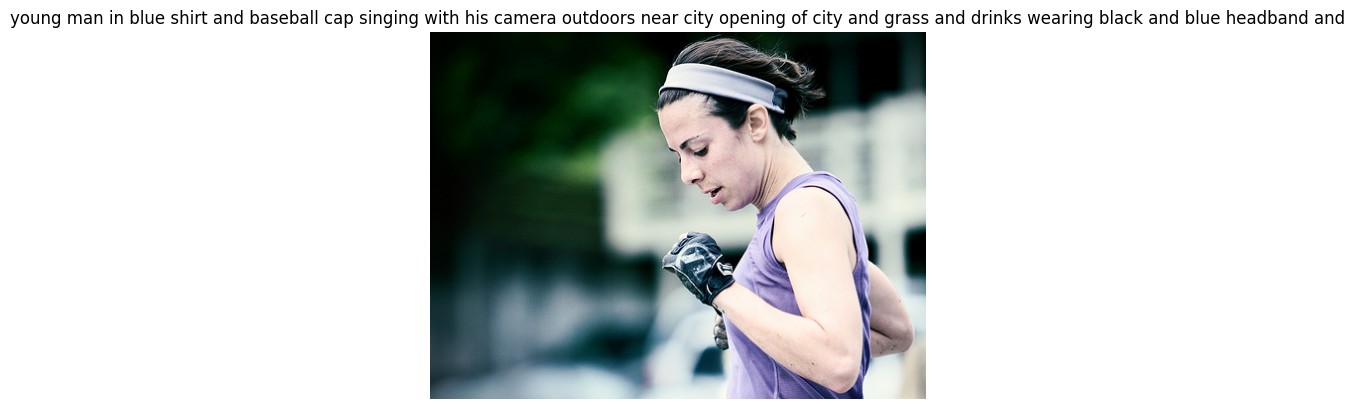

In [56]:

def generate_caption(image_id):
    pic = train_features[image_id]
    pic = np.expand_dims(pic, axis=0)  # Ensure shape is (1, 2048)
    
    caption = greedy_search(pic)
    
    img_path = rf'C:\Users\Lahari\OneDrive\Desktop\image caption\dataset\Images\{image_id}.jpg'
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()


# Provide an image ID from your dataset
image_id = '2773400732_5b65a25857'
generate_caption(image_id)



In [57]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [58]:
# Use a small subset of the data for quick evaluation
val_samples = 100  # Adjust this number to be smaller for faster results

# Assuming X1, X2, and y are your validation data
val_acc = model.evaluate([X1[:val_samples], X2[:val_samples]], y[:val_samples], verbose=0)[1]

print(f"Model Accuracy: {val_acc * 100 :.2f}%")


Model Accuracy: 68.00%
